# Post-process model output

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from glob import glob
import yaml

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cesm_tools

In [3]:
case = 'cam6327_sd.apo-forward.001'

In [7]:
os.getcwd()

'/glade/u/home/mclong/codes/cam-sd-cases/notebooks'

In [14]:
with open(f"caseinfo/{case}.yml") as fid:
    caseinfo = yaml.safe_load(fid)
    
srf_emis_files = caseinfo['srf_emis_files']    
archive_root = caseinfo['archive_root']    
sathist_fincl = caseinfo['sathist_fincl']    
archive_root

'/glade/p/eol/stephens/longcoll/archive/cam6327_sd.apo-forward.001'

In [15]:
with xr.open_dataset(caseinfo['ncdata']) as ds:
    background_ppm = ds.attrs['cam_i_add_uniform_fields_background_ppm']
background_ppm

400.0

In [16]:
data_vars = list(srf_emis_files.keys()) + sathist_fincl
data_vars

['apo_jena',
 'co2_cesm',
 'co2_gridfed',
 'co2_oco2mip',
 'co2_somffn',
 'n2_cesm',
 'n2_era',
 'o2_cesm',
 'o2_gk01r16',
 'o2_gridfed',
 'T',
 'U',
 'V',
 'Q',
 'PS',
 'Z3',
 'PBLH',
 'TMQ',
 'OMEGA']

In [17]:
files = sorted(glob(f"{archive_root}/atm/hist/{case}.cam.hs.*.nc"))
[os.path.basename(f) for f in files]

['cam6327_sd.apo-forward.001.cam.hs.1986-01-01-00000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-01-17-14400.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-11-04-81000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-11-12-18000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2009-11-22-07200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2010-04-01-07200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2010-04-13-84600.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-06-16-75600.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-06-26-14400.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-07-07-63000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-08-11-70200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-08-25-05400.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2011-09-04-00000.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2014-10-20-19800.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2016-01-18-66600.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2016-01-30-79200.nc',
 'cam6327_sd.apo-forward.001.cam.hs.2016-02-18-77400.nc',
 'cam6327_sd.a

In [22]:
%%time
cam_dsets = []
for f in files:
    with xr.open_dataset(f) as ds:
        ds = ds.load()
        
        # convert units
        for v in data_vars:
            if v in srf_emis_files:
                ds[v] = cesm_tools.tracegas_convert_units(
                    ds[v],
                    srf_emis_files[v]["constituent"],
                    background_ppm=background_ppm,
                )        
        
        cam_dsets.append(ds)

CPU times: user 2.9 s, sys: 7.24 s, total: 10.1 s
Wall time: 13.3 s


In [19]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
campaign_keys = ["hip", "orc", "tom", "aoa"]

aircraft_files = {
    'hip': f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    'orc': f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    'tom': f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    'aoa': f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid.nc",
}

obspacks = {}
for key in campaign_keys:
    with xr.open_dataset(aircraft_files[key]) as dsi:
        dsi = dsi[['time', 'latitude', 'longitude', 'altitude', 'value']].load()
        
        for v in data_vars:
            dsi[v] = xr.full_like(dsi.value * cam_dsets[0].lev, fill_value=np.nan)
            dsi[v].attrs = cam_dsets[0][v].attrs
            
        dsi['model_time'] = xr.full_like(dsi.time, fill_value=np.nan)
        obspacks[key] = dsi

obspacks['orc']

<xarray.Dataset>
Dimensions:      (obs: 40217, lev: 32)
Coordinates:
  * lev          (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
Dimensions without coordinates: obs
Data variables: (12/25)
    time         (obs) datetime64[ns] 2016-01-05T19:19:59 ... 2016-03-01T22:4...
    latitude     (obs) float32 39.92 39.91 39.92 39.92 ... 39.89 39.9 39.9 39.9
    longitude    (obs) float32 -105.0 -105.0 -105.1 ... -105.1 -105.1 -105.1
    altitude     (obs) float32 2.191e+03 2.194e+03 ... 1.733e+03 1.707e+03
    value        (obs) float32 0.000404 0.000404 ... 0.0004117 0.0004117
    apo_jena     (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    PS           (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    Z3           (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    PBLH         (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    TMQ          (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    OMEGA        (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    model_time   (obs) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
Attributes: (12/121)
    site_code:                                    ORC
    site_name:                                    ORCAS (O2/N2 Ratio and CO2 ...
    site_country:                                 Chile
    site_country_flag:                            CHIL0001.GIF
    site_latitude:                                -1e+34
    site_longitude:                               -1e+34
    ...                                           ...
    obspack_creation_date:                        2021-08-18T13:54:02.056239
    obspack_warning:                              Every effort is made to cre...
    obspack_fair_use:                             This cooperative data produ...
    obspack_usage_policy:                         www.gml.noaa.gov/ccgg/obspa...
    obspack_identifier_link:                      http://doi.org/10.25925/202...
    obspack_citation:                             Kenneth N. Schuldt, John Mu...

In [26]:
n_key = 0


array([    0,     1,     2, ..., 10121, 10122, 10123])

In [27]:
n_key = 1
np.where(ds.orbit_num == n_key)[0]

array([], dtype=int64)

In [ ]:
%%time

# loop over the sathist datasets
N = 0
for n_key, obspack_key in enumerate(campaign_keys):
    
    obspack = obspacks[obspack_key]
    
    for ds in cam_dsets:
        print(f'{N}')
        
        ndx = np.where(ds.orbit_num == n_key)[0]
        if not len(ndx):
            continue

        I = ds.prof_num.values[ndx]            
        
        # for each column in the dataset, find index into:
        # - the correct obspack file
        # - the correct index into that file
        for i, n in zip(I, ndx):
            # index the right ObsPack dataset                            
            for v in data_vars:            
                obspack[v][i, :] = ds[v][n]
        N += 1

0


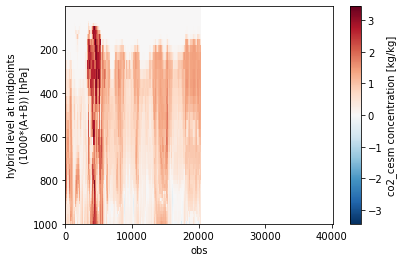

In [11]:
obspacks['orc'].co2_cesm.T.plot(yincrease=False);

In [ ]:
def sathist_to_obspack(da